# Sensitivity analysis of benchmark results

sensitivity to:

* system sizing;
  * PV panel sizing $P_{PVp}$ (kWp)
  * Storage capacity $E_{rated}$ (kWh)
* input data ($P_{load}$ and $P_{sun}$) variability (and length?)

Pierre Haessig, April 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
from scipy.interpolate import interpn

## Preamble

### 1) Load testcase data

reference sizing:

In [2]:
E_rated_ref = 8 # kWh
P_pvp_ref = 4 # kW

In [3]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)

# slice test weeks
df = df['2011-11-29':'2011-12-28'] # 30 test days

n = len(df)
n//48

30

In [4]:
P_load = df.GC
P_sun_1k = df.GG/1.04
P_sun = P_sun_1k*P_pvp_ref

dt = 0.5 # hours
t = np.arange(n)*dt # hours
td = t/24 #days

In [5]:
print('Data from {} to {} ({:.0f} days)'. format(df.index.date[0], df.index.date[-1], td[-1]))
print('* average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('* average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('* ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Data from 2011-11-29 to 2011-12-28 (30 days)
* average sun energy: 15.60 kWh/d
* average load      : 17.02 kWh/d
* ratio sun/load: 91.70%


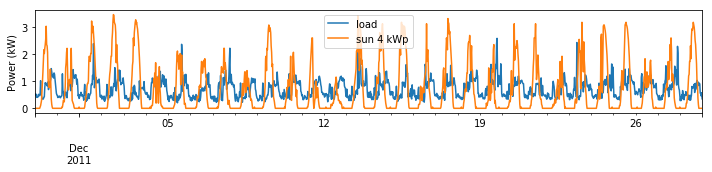

In [6]:
fig = plt.figure(figsize=(10,2.5))
P_load.plot(label='load')
P_sun.plot(label='sun {} kWp'.format(P_pvp_ref))
plt.legend()
plt.ylabel('Power (kW)')
fig.tight_layout()

### 2) Solar home simulation

using rule-based control, taken from [solar_home_rule-based-control.ipynb](../methods/python_rule-based/solar_home_rule-based-control.ipynb)

control strategy: battery should absorb absorb net production, as long as feasible:

$$P_{sto} = -P_{nl} = P_{sun} - P_{load}$$

In [7]:
def control(E_rated, P_load, P_sun, E_sto):
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0
    P_grid = 0
    P_curt = 0
    
    E_next = E_sto - P_nl*dt
    
    if P_nl>0: # (load > sun)
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0
        P_grid = P_nl + P_sto
    else:
        E_next = E_next if E_next<E_rated else E_rated
        P_sto = (E_next - E_sto)/dt # >0
        P_curt = -P_nl - P_sto
    return P_sto, P_grid, P_curt

Computation of grid energy cost:

depends on the hour of the day $h$:

* $0 \leq h < 6$: night price 0.10 €/kWh
* $6 \leq h < 24$: day price:  0.20 €/kWh

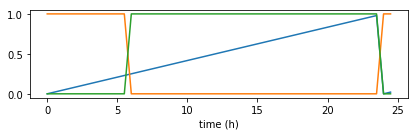

In [8]:
h = (np.arange(n)*dt) % 24
night = h < 6
day = ~night

plt.figure(figsize=(6,2))
z = slice(0, 50)
plt.plot(t[z], h[z]/24)
plt.plot(t[z], night[z])
plt.plot(t[z], day[z])
plt.xlabel('time (h)')
plt.tight_layout()

In [9]:
def home_sim(E_rated, P_pvp, P_load, P_sun_1kW):
    '''simulate solar home with parameters `E_rated` and `P_pvp`
    and data `P_load`, `P_sun_1kW`
    '''
    n = len(P_load)
    P_sun = P_sun_1kW*P_pvp
    P_sto = np.zeros(n)
    E_sto = np.zeros(n+1)
    P_grid = np.zeros(n)
    P_curt = np.zeros(n)

    E_sto[0]= E_rated/2

    for k in range(n):
        P_sto[k], P_grid[k], P_curt[k] = control(E_rated, P_load[k], P_sun[k], E_sto[k])
        E_sto[k+1] = E_sto[k] + P_sto[k]*dt
        assert 0 <= E_sto[k+1] <= E_rated

    # extra outputs
    E_sto = E_sto[:-1]
    P_pv = P_sun - P_curt
    P_nl = P_load - P_sun
    
    # grid energy cost
    h = (np.arange(n)*dt) % 24 # in [0, 24[
    night = h < 6
    day = ~night
    C_grid = P_grid*0.10*night + P_grid*0.20*day
    
    # stats: cumulated energy in kWh/day
    stats = dict(
        E_load = P_load.mean()*24,
        E_sun  = P_sun.mean()*24,
        E_pv   = P_pv.mean()*24,
        E_curt = P_curt.mean()*24,
        E_grid = P_grid.mean()*24,
        C_grid = C_grid.mean()*24,
    )
    # full output: out = pd.DataFrame()
    return stats

In [10]:
%time home_sim(E_rated_ref, P_pvp_ref, P_load, P_sun_1k)

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 39 ms


{'C_grid': 0.5633069230769231,
 'E_curt': 1.9399538461538457,
 'E_grid': 3.378017948717949,
 'E_load': 17.01703333333333,
 'E_pv': 13.66414871794871,
 'E_sun': 15.604102564102572}

In [11]:
def pprint_stats(stats):
    'pretty print energy stats'
    s = '''E_load: {E_load:6.2f} kWh/d (data)
E_sun:  {E_sun:6.2f} kWh/d (data)
E_pv:   {E_pv:6.2f} kWh/d
E_curt: {E_curt:6.2f} kWh/d
E_grid: {E_grid:6.2f} kWh/d
C_grid: {C_grid:6.3f} €/d
'''.format(**stats)
    print(s)

In [12]:
pprint_stats(home_sim(E_rated_ref, P_pvp_ref, P_load, P_sun_1k))

E_load:  17.02 kWh/d (data)
E_sun:   15.60 kWh/d (data)
E_pv:    13.66 kWh/d
E_curt:   1.94 kWh/d
E_grid:   3.38 kWh/d
C_grid:  0.563 €/d



## Sizing effect: parametric study

effect of storage size and PV size

### Parameter grid

In [13]:
nE = 41
E_rated_max = 20 # kWh
E_rated_list = np.linspace(0, E_rated_max, nE) 
dE = E_rated_list[1] - E_rated_list[0]
dE # step, kWh

0.5

In [14]:
nPV = 37
P_pv_max = 6 # kW_peak
P_pvp_list = np.linspace(0, P_pv_max, nPV) 
dP = P_pvp_list[1] - P_pvp_list[0]
dP # step, kW_peak

0.16666666666666666

meshed grid of the parameters:

In [15]:
XP, YE = np.meshgrid(P_pvp_list, E_rated_list)

In [17]:
print('nb of param values: {}. Simulation time: ~{:.0f} s'.format(nE*nPV, 50e-3*nE*nPV))

nb of param values: 1517. Simulation time: ~76 s


### Run sim

batch simulation... (40 ms/pt)

In [18]:
EP_stats_list = []
for E_rated in E_rated_list:
    for P_pvp in P_pvp_list:
        stats = home_sim(E_rated, P_pvp, P_load, P_sun_1k)
        stats['E_rated'] = E_rated
        stats['P_pvp'] = P_pvp
        EP_stats_list.append(stats)

In [19]:
EP_stats = pd.DataFrame(EP_stats_list)
# cosmetic: reorder the columns: parameters first, outputs at the end
cols = ['E_rated', 'P_pvp', 'E_load', 'E_sun', 'E_pv', 'E_curt', 'E_grid', 'C_grid']
assert len(EP_stats.columns) == len(cols)
EP_stats = EP_stats.reindex_axis(cols, axis=1)
EP_stats.head()

,E_rated,P_pvp,E_load,E_sun,E_pv,E_curt,E_grid,C_grid
0,0.0,0.000000,17.017033,0.000000,0.000000,0.000000,17.017033,3.140563
1,0.0,0.166667,17.017033,0.650171,0.650171,0.000000,16.366862,3.010555
2,0.0,0.333333,17.017033,1.300342,1.300342,0.000000,15.716691,2.880546
3,0.0,0.500000,17.017033,1.950513,1.949149,0.001363,15.067884,2.750810
4,0.0,0.666667,17.017033,2.600684,2.584343,0.016341,14.432691,2.623797


Folded output stats: 2D array of shape `(nE, nPV)`

In [20]:
E_grid_rs = EP_stats.E_grid.values.reshape((nE, nPV))
C_grid_rs = EP_stats.C_grid.values.reshape((nE, nPV))
E_curt_rs = EP_stats.E_curt.values.reshape((nE, nPV))

#### 1D plots of output stats

preamble: find grid point closest to reference values

In [21]:
iE = np.flatnonzero(E_rated_list>=E_rated_ref)[0]
iP = np.flatnonzero(P_pvp_list>=P_pvp_ref)[0]
E_rated_list[iE], P_pvp_list[iP]

(8.0, 4.0)

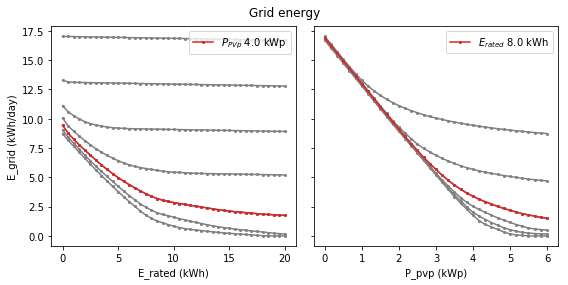

In [24]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].plot(E_rated_list, E_grid_rs[:,::6], 'o-', ms=2, color='gray')
ax[0].plot(E_rated_list, E_grid_rs[:,iP], 'o-', ms=2, color='tab:red',
           label='$P_{{PVp}}$ {:.1f} kWp'.format(P_pvp_list[iP]))
ax[1].plot(P_pvp_list, E_grid_rs[::8,:].T, 'o-', ms=2, color='gray')
ax[1].plot(P_pvp_list, E_grid_rs[iE,:], 'o-', ms=2, color='tab:red',
           label='$E_{{rated}}$ {:.1f} kWh'.format(E_rated_list[iE]))

ax[0].set(xlabel='E_rated (kWh)', ylabel='E_grid (kWh/day)')
ax[1].set(xlabel='P_pvp (kWp)')
ax[0].legend(loc='upper right')
ax[1].legend()

fig.suptitle('Grid energy')
fig.tight_layout(rect=(0, 0, 1, 0.96))

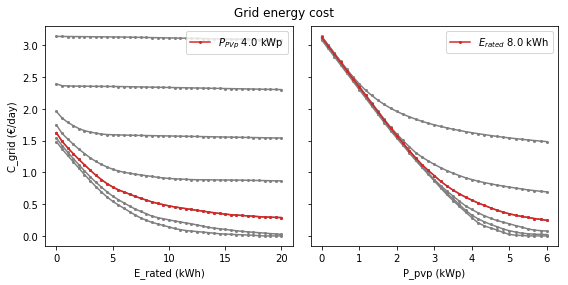

In [26]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].plot(E_rated_list, C_grid_rs[:,::6], 'o-', ms=2, color='gray')
ax[0].plot(E_rated_list, C_grid_rs[:,iP], 'o-', ms=2, color='tab:red',
           label='$P_{{PVp}}$ {:.1f} kWp'.format(P_pvp_list[iP]))
ax[1].plot(P_pvp_list, C_grid_rs[::8,:].T, 'o-', ms=2, color='gray')
ax[1].plot(P_pvp_list, C_grid_rs[iE,:], 'o-', ms=2, color='tab:red',
           label='$E_{{rated}}$ {:.1f} kWh'.format(E_rated_list[iE]))

ax[0].set(xlabel='E_rated (kWh)', ylabel='C_grid (€/day)')
ax[1].set(xlabel='P_pvp (kWp)')
ax[0].legend(loc='upper right')
ax[1].legend()

fig.suptitle('Grid energy cost')
fig.tight_layout(rect=(0, 0, 1, 0.96))

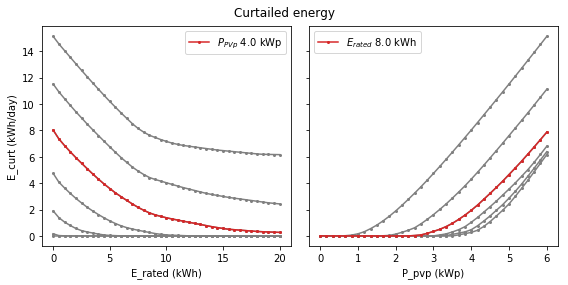

In [27]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].plot(E_rated_list, E_curt_rs[:,::6], 'o-', ms=2, color='gray')
ax[0].plot(E_rated_list, E_curt_rs[:,iP], 'o-', ms=2, color='tab:red',
           label='$P_{{PVp}}$ {:.1f} kWp'.format(P_pvp_list[iP]))
ax[1].plot(P_pvp_list, E_curt_rs[::8,:].T, 'o-', ms=2, color='gray')
ax[1].plot(P_pvp_list, E_curt_rs[iE,:], 'o-', ms=2, color='tab:red',
           label='$E_{{rated}}$ {:.1f} kWh'.format(E_rated_list[iE]))

ax[0].set(xlabel='E_rated (kWh)', ylabel='E_curt (kWh/day)')
ax[1].set(xlabel='P_pvp (kWp)')
ax[0].legend(loc='upper right')
ax[1].legend()

fig.suptitle('Curtailed energy')
fig.tight_layout(rect=(0, 0, 1, 0.96))

### 2D sizing plots

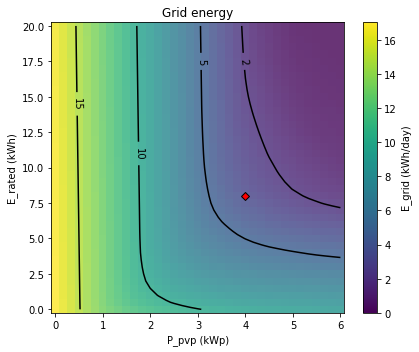

In [31]:
fig, ax = plt.subplots(figsize=(6,5))

imparams = dict(origin='lower',
                extent=[-dP/2, P_pv_max+dP/2, -dE/2, E_rated_max+dE/2],
                aspect='auto')
im = ax.imshow(E_grid_rs, **imparams, alpha=0.8)
ax.plot(P_pvp_ref, E_rated_ref, 'rD', mec='k')
CS = ax.contour(XP, YE, E_grid_rs, [2, 5, 10, 15], colors='k')
ax.clabel(CS, fmt='%.2g')
cbar = fig.colorbar(im)
cbar.set_label('E_grid (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188
ax.set(title='Grid energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

fig.savefig('Sizing_E_grid_heatmap.png', dpi=150)

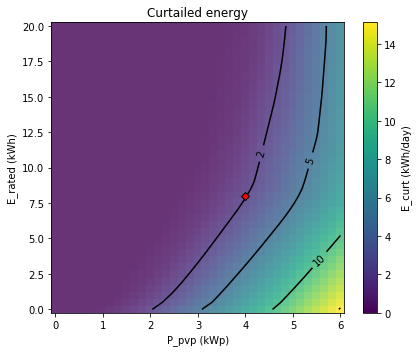

In [32]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(E_curt_rs, **imparams, alpha=0.8)
ax.plot(P_pvp_ref, E_rated_ref, 'rD', mec='k')
CS = ax.contour(XP, YE, E_curt_rs, [2, 5, 10, 15], colors='k')
ax.clabel(CS, fmt='%.0f')
cbar = fig.colorbar(im)
cbar.set_label('E_curt (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188

ax.set(title='Curtailed energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout()

fig.savefig('Sizing_E_curt_heatmap.png', dpi=150)

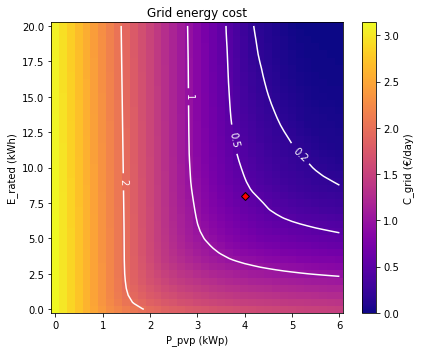

In [33]:
fig, ax = plt.subplots(figsize=(6,5))

imparams = dict(origin='lower',
                extent=[-dP/2, P_pv_max+dP/2, -dE/2, E_rated_max+dE/2],
                aspect='auto')
im = ax.imshow(C_grid_rs, **imparams, cmap='plasma')
ax.plot(P_pvp_ref, E_rated_ref, 'rD', mec='k')
CS = ax.contour(XP, YE, C_grid_rs, [0.2, 0.5, 1, 2], colors='w')
ax.clabel(CS, fmt='%.1g')
cbar = fig.colorbar(im)
cbar.set_label('C_grid (€/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188
ax.set(title='Grid energy cost', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

fig.savefig('Sizing_C_grid_heatmap.png', dpi=150)

#### Comparison between grid energy and grid cost. 

Question: is the "knee" of the iso lines in the same area?

* Answer: yes
* at least with this rule-based control

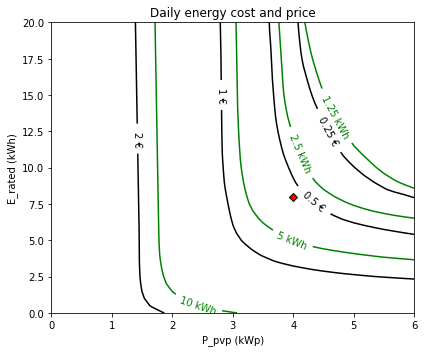

In [35]:
fig, ax = plt.subplots(figsize=(6,5))

CSC = ax.contour(XP, YE, C_grid_rs, [0.25, 0.5, 1, 2], colors='k')
ax.clabel(CSC, fmt='%.2g €')

CSE = ax.contour(XP, YE, E_grid_rs, [1.25, 2.5, 5, 10], colors='g')
ax.clabel(CSE, fmt='%.3g kWh')

ax.plot(P_pvp_ref, E_rated_ref, 'rD', mec='k')

ax.set(title='Daily energy cost and price', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

#### Quick look at avg grid energy price

avg price = energy/cost (should be between day price and night price)

In [36]:
P_grid_avg_rs = C_grid_rs/E_grid_rs
# remove values where quantities are close to zero
P_grid_avg_rs[E_grid_rs<E_grid_rs.max()/100] = np.nan

highest avg price:

In [37]:
np.nanmax(P_grid_avg_rs)

0.18502534920425373

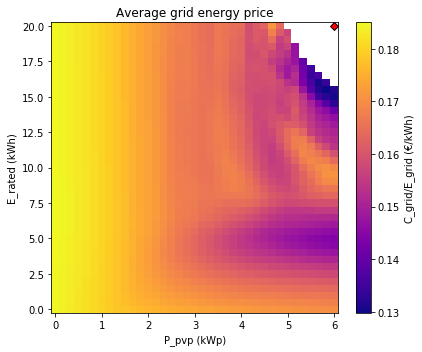

In [38]:
fig, ax = plt.subplots(figsize=(6,5))

imparams = dict(origin='lower',
                extent=[-dP/2, P_pv_max+dP/2, -dE/2, E_rated_max+dE/2],
                aspect='auto')
im = ax.imshow(P_grid_avg_rs, **imparams, cmap='plasma')
ax.plot(P_pvp, E_rated, 'rD', mec='k')
cbar = fig.colorbar(im)
cbar.set_label('C_grid/E_grid (€/kWh)')
ax.set(title='Average grid energy price', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

fig.savefig('Sizing_P_grid_heatmap.png', dpi=150)

Observation: 

* max of avg price: when no PV: .185 €kWh, smaller but quite close to the day price. Indeed, most load comes during the day and also the day price covers 3/4 of the day.
* when adding a bit of PV, avg price drops (since PV arrives during the day)
* rule-based control doesn't manage the time-variying price well. At 4 kWp, the increase of battery capacity from 5 to 7.5 increases the avg price (although not the cost!)

### Cost analysis over lifecycle


#### a) Investment cost

simple linear cost function:

$$ C_{inv} = c_P P_{PVp}+ c_E E_{rated} $$

* $c_P$ 2 €/Wc 
  * "HT, pour 9 à 36 kWc, ISB" http://www.photovoltaique.info/Couts-d-investissement.html
* $c_E$ 0.5 €/kWh 
  * [Tesla Powerwall](https://www.tesla.com/fr_FR/powerwall) 7 k€/13.5 kWh

In [39]:
cP = 2 # k€/kWp
cE = 0.5 # k€/kWh
cost = XP*cP + YE*cE

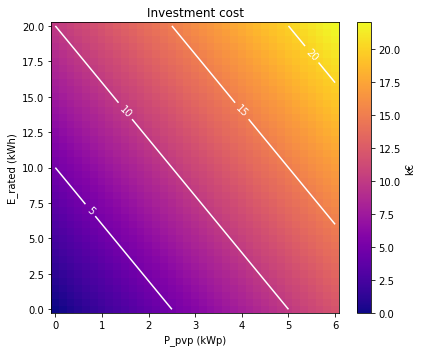

In [40]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(cost, **imparams, cmap='plasma', alpha=1)
#ax.plot(3, 10, 'bD', mec='k')
CS = ax.contour(XP, YE, cost, [5, 10, 15, 20], colors='w')
ax.clabel(CS, fmt='%.0f')
cbar = fig.colorbar(im)
cbar.set_label('k€')

ax.set(title='Investment cost', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout()

fig.savefig('Invest_cost_heatmap.png', dpi=150)

Superposition: energy consumption with investment

how to read: for a given investment cost, the optimal sizing is at the tangence of an iso-operation cost

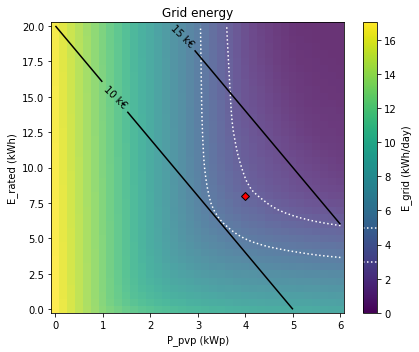

In [48]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(E_grid_rs, **imparams, alpha=0.8)
ax.plot(P_pvp_ref, E_rated_ref, 'rD', mec='k')
CSE = ax.contour(XP, YE, E_grid_rs, [3, 5], colors='w', linestyles=':')


CSc = ax.contour(XP, YE, cost, [10, 15], colors='k')
ax.clabel(CSc, fmt='%.0f k€')
cbar = fig.colorbar(im)
cbar.add_lines(CSE)
cbar.lines[0].set_linestyles(':')
cbar.set_label('E_grid (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188

ax.set(title='Grid energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout()

fig.savefig('Sizing_E_grid_invest_heatmap.png', dpi=150)

#### b) Operation cost

hyp: E_grid priced at 0.2 €/kWh on 20 years

#### c) Total cost

**TODO** compute automatically 

* the optimum (E,P) *point* which minimizes the total cost
* and/or the optimum (E,P) *region* which is with a few % of the minimum.

In [58]:
c_grid = 0.20 # €/kWh on 20 years
cost_tot = cost+E_grid_rs*20*365.25*c_grid/1000

In [42]:
def total_cost_map(c_grid, save=False):
    fig, ax = plt.subplots(figsize=(6,5))
    
    cost_tot = cost+E_grid_rs*20*365.25*c_grid/1000
    im = ax.imshow(cost_tot, **imparams, cmap='plasma',
                   vmin=15, vmax=40) # fix v range for making series of plots
    ax.plot(P_pvp_ref, E_rated_ref, 'D', mec='k', color=(0,1,0), label='bench sizing')
    CS = ax.contour(XP, YE, cost_tot, [16, 18, 20], colors='w')
    ax.clabel(CS, fmt='%.0f')
    cbar = fig.colorbar(im)
    cbar.add_lines(CS)
    cbar.set_label('k€')

    ax.set(
        title='Total cost\n on 20 yr, grid at {:.2f} €/kWh'.format(c_grid),
        xlabel='P_pvp (kWp)',
        ylabel='E_rated (kWh)'
    )
    fig.tight_layout();
    if save:
        fig.savefig('Total_cost_map_grid{:.2f}.png'.format(c_grid), dpi=150)

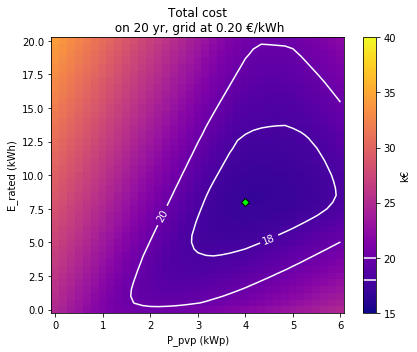

In [43]:
total_cost_map(0.20)

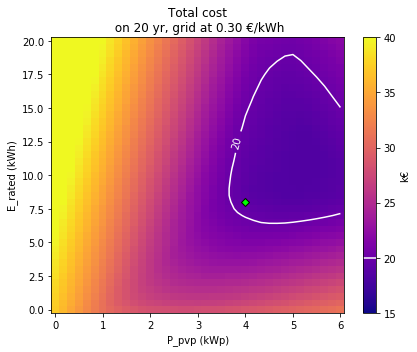

In [49]:
for cgrid in np.arange(15, 31)/100:
    plt.close()
    total_cost_map(cgrid, save=True)

#### Sizing with fix investment

inverting the investement cost function:

$$ C_{inv} = c_P P_{PVp}+ c_E E_{rated} $$

becomes:

$$ E_{rated}(P_{PVp}) = (C_{inv} - c_P P_{PVp})/c_E$$

for $P_{PVp}$ between 0 and $C_{inv}/c_P$ (to keep $E_{rated}>0$)

In [51]:
Cinv_ref = cP*P_pvp_ref + cE*E_rated_ref
Cinv_ref # k€

12.0

In [52]:
P_pvp_range = np.linspace(1, Cinv_ref/cP, 30) # start at 1kW to keep E_rated <= 20 kWh
P_pvp_range[-1]

6.0

In [53]:
E_rated_range = (Cinv_ref - P_pvp_range*cP)/cE
E_rated_range[0]

20.0

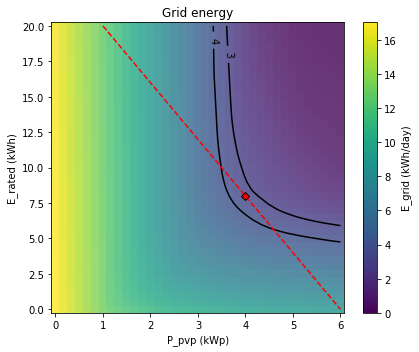

In [105]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(E_grid_rs, **imparams, alpha=0.8)
ax.plot(P_pvp_range, E_rated_range, 'r--')
ax.plot(P_pvp_ref, E_rated_ref, 'rD', mec='k')
CS = ax.contour(XP, YE, E_grid_rs, [3, 4], colors='k')
ax.clabel(CS, fmt='%.0f')
cbar = fig.colorbar(im)
cbar.set_label('E_grid (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188
ax.set(title='Grid energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

In [ ]:
def eval_fixinvest(stat_2):
    '''eval `stat_2` 2D array on fixed investment line
    '''
    xi = np.vstack([E_rated_range, P_pvp_range]).T
    
    stat_range = interpn(
        (E_rated_list, P_pvp_list),
        stat_2,
        xi
    )
    return stat_range

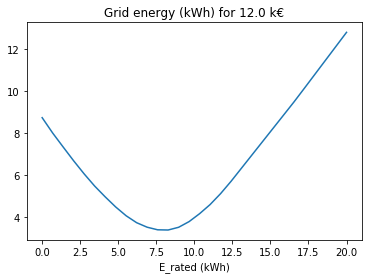

In [111]:
plt.plot(E_rated_range, eval_fixinvest(E_grid_rs))
plt.title('Grid energy (kWh) for {} k€'.format(Cinv_ref))
plt.xlabel('E_rated (kWh)');

Obs: The 8 kWh sizing is coherent with this curve

#### 3D plot

In [54]:
from mpl_toolkits.mplot3d import Axes3D

In [55]:
%matplotlib inline

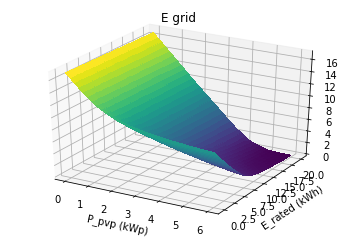

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(XP, YE, E_grid_rs, cmap='viridis', antialiased=False)
ax.set(title='E grid', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)');

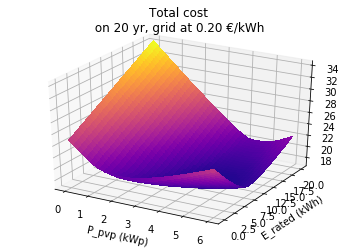

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(XP, YE, cost_tot, cmap='plasma', antialiased=False)
ax.set(
    title='Total cost\n on 20 yr, grid at {:.2f} €/kWh'.format(c_grid),
    xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)');

## Uncertainty effect on the energy statistics

### Load input data bootstrap (P_sun, P_load)

load bootstrap data generated in [data_variability_bootstrap.ipynb](../data/data_variability_bootstrap.ipynb)

In [60]:
df_bs = pd.read_csv('../data/test-data_2011-11-29_30-days_bl-3_bs-400.csv', index_col=0, parse_dates=True)
df_bs.head(3)

,GC0,GG0,GC1,GG1,GC2,GG2,GC3,GG3,GC4,GG4,...,GC395,GG395,GC396,GG396,GC397,GG397,GC398,GG398,GC399,GG399
2011-11-29 00:00:00,0.468,0.0,0.436,0.0,0.310,0.0,0.386,0.0,0.482,0.0,...,0.580,0.0,0.428,0.0,0.510,0.0,0.338,0.0,0.482,0.0
2011-11-29 00:30:00,0.504,0.0,0.432,0.0,0.452,0.0,0.266,0.0,0.344,0.0,...,0.626,0.0,0.710,0.0,0.538,0.0,0.366,0.0,0.344,0.0
2011-11-29 01:00:00,0.394,0.0,0.488,0.0,0.252,0.0,0.284,0.0,0.376,0.0,...,0.578,0.0,0.402,0.0,0.448,0.0,0.568,0.0,0.376,0.0


In [61]:
nsamp = len(df_bs.columns)//2
nsamp

400

split data:

* load
* sun, with scaling to 1 kWp

In [66]:
P_load_bs = df_bs.iloc[:,range(0,nsamp*2, 2)]
P_load_bs.columns = range(nsamp)
P_load_bs.head(2)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
2011-11-29 00:00:00,0.468,0.436,0.310,0.386,0.482,0.386,0.432,0.672,0.386,0.428,...,0.436,0.436,0.338,0.386,0.842,0.580,0.428,0.510,0.338,0.482
2011-11-29 00:30:00,0.504,0.432,0.452,0.266,0.344,0.266,0.316,0.560,0.266,0.710,...,0.432,0.432,0.366,0.266,0.416,0.626,0.710,0.538,0.366,0.344


In [65]:
P_sun_1k_bs = df_bs.iloc[:,range(1,nsamp*2, 2)]/1.04
P_sun_1k_bs.columns = range(nsamp)
P_sun_1k_bs.head(2)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
2011-11-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-29 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Quick data check

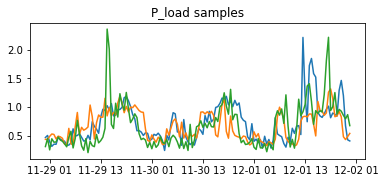

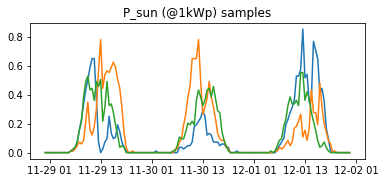

In [67]:
plt.figure(figsize=(6,2.5))
plt.plot(P_load_bs.iloc[:48*3,:3])
plt.title('P_load samples')

plt.figure(figsize=(6,2.5))
plt.plot(P_sun_1k_bs.iloc[:48*3,:3])
plt.title('P_sun (@1kWp) samples');

### Run solar home sim on each scenario

Batch sim ~ 16 s

In [68]:
40e-3 * 400

16.0

In [69]:
E_rated_ref, P_pvp_ref

(8, 4)

In [70]:
bs_stats = []
for i in range(nsamp):
    stats = home_sim(E_rated_ref, P_pvp_ref, P_load_bs[i], P_sun_1k_bs[i])
    bs_stats.append(stats)

In [71]:
bs_stats = pd.DataFrame(bs_stats)
bs_stats['E_nl'] = bs_stats.E_load - bs_stats.E_sun
bs_stats.head(2)

,C_grid,E_curt,E_grid,E_load,E_pv,E_sun,E_nl
0,0.637001,2.140149,3.861659,16.899933,13.007159,15.147308,1.752626
1,0.554001,1.686764,3.244746,17.397167,14.099005,15.785769,1.611397


**TODO** reorder the columns (e.g. for the scatter plot)

In [72]:
bs_stats.describe(percentiles=[0.025, 0.975])

,C_grid,E_curt,E_grid,E_load,E_pv,E_sun,E_nl
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.568420,1.930973,3.407228,17.033584,13.556331,15.487304,1.546280
std,0.087039,0.536385,0.505198,0.327569,0.573920,0.961932,0.940237
min,0.350226,0.477362,2.153490,16.178533,12.047226,12.793205,-0.972462
2.5%,0.384351,0.893543,2.398383,16.426194,12.393988,13.441099,-0.200475
50%,0.567238,1.894053,3.373963,17.028067,13.564173,15.544103,1.542191
97.5%,0.736680,2.986444,4.432953,17.752513,14.699029,17.261795,3.391600
max,0.812127,3.588233,4.880692,18.267800,14.907762,17.882564,4.140562


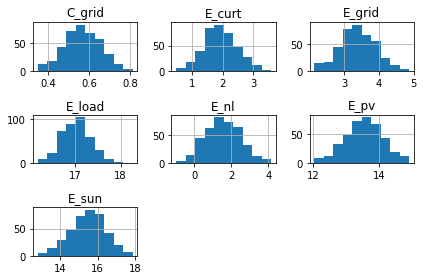

In [73]:
bs_stats.hist();
plt.tight_layout()

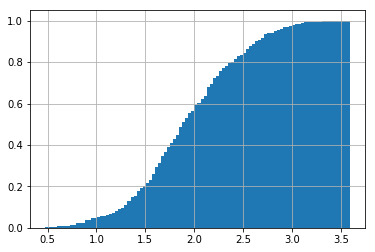

In [74]:
bs_stats.E_curt.hist(cumulative=True, bins=100, density=True);

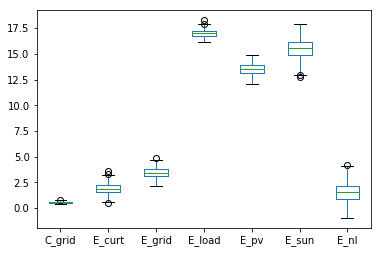

In [75]:
bs_stats.plot.box();

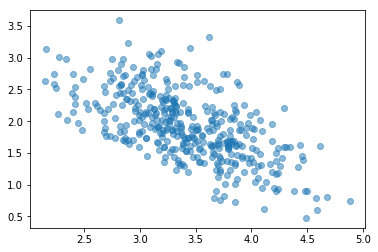

In [76]:
plt.plot(bs_stats.E_grid, bs_stats.E_curt, 'o', alpha=0.5);

In [77]:
from pandas.plotting import scatter_matrix

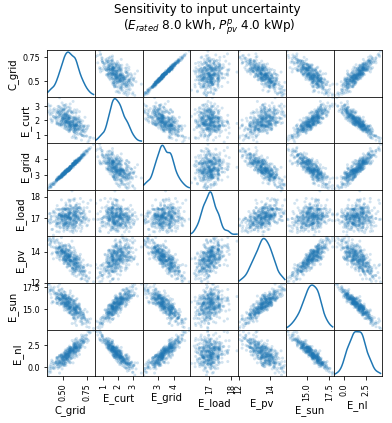

In [125]:
scatter_matrix(bs_stats, alpha=0.2, figsize=(6, 6), diagonal='kde')
title = 'Sensitivity to input uncertainty \n' +\
        '($E_{{rated}}$ {:.1f} kWh, $P_{{pv}}^p$ {:.1f} kWp)'.format(E_rated_ref, P_pvp_ref)
plt.suptitle(title);

fname = 'Input_uncertain_scat_E{:.0f}_P{:.0f}'.format(E_rated_ref, P_pvp_ref)
plt.savefig(fname + '.pdf')
plt.savefig(fname + '.png', dpi=150)

---

Plot trajectories. NOT YET DONE

## Cross effect of sizing and input uncertainty

TODO: run solar home simulation:

* for each bootstrapped sample
* for each sizing param (E_rated, P_pvp)

to see how the sizing is affected.

Open questions:

* is the optimal ratio E/P changing (e.g. the position of the "knee" of the iso-P_grid lines)
* is the global size changing: bigger battery AND bigger panels?

### Parameter grid

In [79]:
nE = 20*2+1
E_rated_max = 20 # kWh
E_rated_list = np.linspace(0, E_rated_max, nE) 
dE = E_rated_list[1] - E_rated_list[0]
dE # step, kWh

0.5

In [80]:
nPV = 6*6+1
P_pv_max = 6 # kW_peak
P_pvp_list = np.linspace(0, P_pv_max, nPV) 
dP = P_pvp_list[1] - P_pvp_list[0]
dP # step, kW_peak

0.16666666666666666

meshed versions:

In [81]:
XP, YE = np.meshgrid(P_pvp_list, E_rated_list)

Number of samples to use

In [82]:
ns = 30
assert ns < nsamp, 'cannot select more samples than available'

In [83]:
print('nb of param values: {}. Simulation time: ~{:.1f} s'.format(nE*nPV*ns, 50e-3*nE*nPV*ns))

nb of param values: 45510. Simulation time: ~2275.5 s


Prepare output stats in a 3D array with shape `(nE, nPV, ns)`

In [195]:
E_grid_3 = np.zeros((nE, nPV, ns))
C_grid_3 = np.zeros((nE, nPV, ns))
E_curt_3 = np.zeros((nE, nPV, ns))

Batch run

In [196]:
for i, E_rated in enumerate(E_rated_list):
    print('E_rated: {}/{}'.format(i,nE))
    for j, P_pvp in enumerate(P_pvp_list):
        for k in range(ns):
            stats = home_sim(E_rated, P_pvp, P_load_bs[k], P_sun_1k_bs[k])
            E_grid_3[i,j,k] = stats['E_grid']
            C_grid_3[i,j,k] = stats['C_grid']
            E_curt_3[i,j,k] = stats['E_curt']

E_rated: 0/41
E_rated: 1/41
E_rated: 2/41
E_rated: 3/41
E_rated: 4/41
E_rated: 5/41
E_rated: 6/41
E_rated: 7/41
E_rated: 8/41
E_rated: 9/41
E_rated: 10/41
E_rated: 11/41
E_rated: 12/41
E_rated: 13/41
E_rated: 14/41
E_rated: 15/41
E_rated: 16/41
E_rated: 17/41
E_rated: 18/41
E_rated: 19/41
E_rated: 20/41
E_rated: 21/41
E_rated: 22/41
E_rated: 23/41
E_rated: 24/41
E_rated: 25/41
E_rated: 26/41
E_rated: 27/41
E_rated: 28/41
E_rated: 29/41
E_rated: 30/41
E_rated: 31/41
E_rated: 32/41
E_rated: 33/41
E_rated: 34/41
E_rated: 35/41
E_rated: 36/41
E_rated: 37/41
E_rated: 38/41
E_rated: 39/41
E_rated: 40/41


Save precious results

In [197]:
np.savez('sizing_bs.npz',
         E_grid_3 = E_grid_3,
         C_grid_3 = C_grid_3,
         E_curt_3 = E_curt_3
        )

In [86]:
sizing_bs_npz = np.load('sizing_bs.npz')
E_grid_3 = sizing_bs_npz['E_grid_3']
C_grid_3 = sizing_bs_npz['C_grid_3']
E_curt_3 = sizing_bs_npz['E_curt_3']

In [121]:
imparams = dict(origin='lower',
                extent=[-dP/2, P_pv_max+dP/2, -dE/2, E_rated_max+dE/2],
                aspect='auto')

def stats_map(k=0, which='E_grid'):
    '''plot stat array sliced for bootstrapped scenar `k`
    plot is a heatmap function of (E_rated, P_pv)
    '''
    assert k < ns, 'scenerio index should be smaller than ns'
    fig, ax = plt.subplots(figsize=(6,5))
    
    if which == 'E_grid':
        Z3 = E_grid_3
        unit = 'kWh/day'
        title = 'Grid energy'
        levels = [2, 5, 10, 15]
    elif which == 'C_grid':
        Z3 = C_grid_3
        unit = '€/day'
        title = 'Grid energy cost'
        levels = [0.2, 0.5, 1, 2]
    elif which == 'E_curt':
        Z3 = E_curt_3
        unit = 'kWh/day'
        title = 'Curtailed energy'
        levels = [2, 5, 10, 15]
        
    im = ax.imshow(Z3[:,:,k], **imparams, alpha=0.8)
    ax.plot(P_pvp_ref, E_rated_ref, 'rD', mec='k', label='ref')
    CS = ax.contour(XP, YE, Z3[:,:,k], levels, colors='k')
    ax.clabel(CS, fmt='%.3g')
    cbar = fig.colorbar(im)
    cbar.set_label('{} ({})'.format(which, unit))
    cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188
    ax.set(
        title='{} (scenar {})'.format(title, k),
        xlabel='P_pvp (kWp)',
        ylabel='E_rated (kWh)')
    fig.tight_layout();
    ax.legend()
    
    fname = 'Sizing_{}_s{}_heatmap.png'.format(which, k)
    #fig.savefig('Sizing_E_grid_heatmap.png', dpi=150)

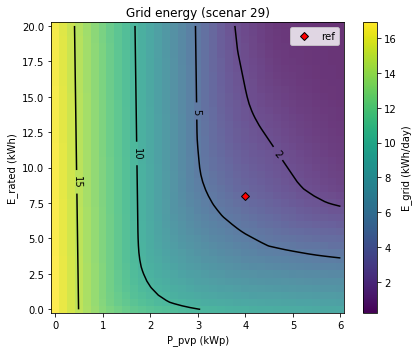

In [122]:
stats_map(29, 'E_grid')

In [89]:
from ipywidgets import interact

TODO: add ref point + value at point

In [123]:
interact(stats_map, k=(0, ns-1), which=['E_grid', 'C_grid', 'E_curt']);

interactive(children=(IntSlider(value=0, description='k', max=29), Dropdown(description='which', options=('E_grid', 'C_grid', 'E_curt'), value='E_grid'), Output()), _dom_classes=('widget-interact',))

Relative change

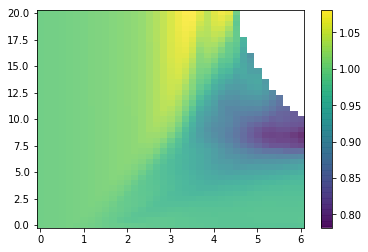

In [91]:
k = 2
Z3 = E_grid_3
Z3m = Z3.mean(axis=2)
Z3_rel = Z3[:,:,k]/Z3m
Z3_rel[Z3m<Z3m.max()/20] = np.nan
im = plt.imshow(Z3_rel, **imparams, alpha=0.8)
cbar = plt.colorbar(im)

TODO sizing study.

* Plot stat (grid energy or cost) on a iso-investement line (E,P s.t. cE*E+cP*P = cst). **DONE**
* Compute the (E,P) region where cost is smaller than 1+eps of the min

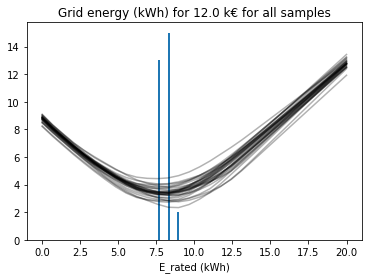

In [120]:
E_rated_opt = []
for k in range(ns):
    E_range = eval_fixinvest(E_grid_3[:,:,k])
    imin = np.argmin(E_range)
    E_rated_opt.append(E_rated_range[imin])
    plt.plot(E_rated_range, E_range, 'k-', alpha=0.3)
    
    
plt.title('Grid energy (kWh) for {} k€ for all samples'.format(Cinv_ref))
plt.xlabel('E_rated (kWh)')
plt.hist(E_rated_opt);